In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import time
from DSH import MIfile as MI
from DSH import Config as cf
from DSH import ROIproc as RP
from DSH import SharedFunctions as sf
from DSH import IOfunctions as iof

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('Drift correction tutorial started')

INFO:root:Drift correction tutorial started


# Processing speckle translations

Let's restart from the speckle movie from tutorial 4:

In [2]:
froot = r'..\ROI_test'
MIinput = MI.MIfile(os.path.join(froot, 'MI.raw'), os.path.join(froot, 'MI_metadata.ini'))
MIinput.OpenForReading()
im1 = MIinput.GetImage(0)
plt.imshow(im1)
plt.colorbar()

DEBUG:root:MIfile object created with filename ..\ROI_test\MI.raw
DEBUG:root:Now loading MIfile metadata (from filename: ..\ROI_test\MI_metadata.ini)


OSError: Configuration file ..\ROI_test\MI_metadata.ini not found

DEBUG:root:MIfile object created with filename D:\Data\RheoSALS\231010\SALS\xp2628_3.5per\RheoSals\231108_xp2626_3per_tracers0p5um\0.01mms-1\PS_NEG\000_DLS.raw
DEBUG:root:Now loading MIfile metadata (from filename: D:\Data\RheoSALS\231010\SALS\xp2628_3.5per\RheoSals\231108_xp2626_3per_tracers0p5um\0.01mms-1\PS_NEG\000_DLS_metadata.ini)
DEBUG:root:Loading config file D:\Data\RheoSALS\231010\SALS\xp2628_3.5per\RheoSals\231108_xp2626_3per_tracers0p5um\0.01mms-1\PS_NEG\000_DLS_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']


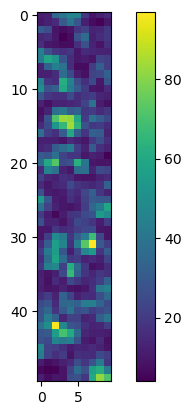

In [2]:
froot = r'D:\Data\RheoSALS\231010\SALS\xp2628_3.5per\RheoSals\231108_xp2626_3per_tracers0p5um\0.01mms-1\PS_NEG'
MIinput = MI.MIfile(os.path.join(froot, '000_DLS.raw'), os.path.join(froot, '000_DLS_metadata.ini'))
MIinput.OpenForReading()
cropROI = [660, 470, 10, 50]
im1 = MIinput.GetImage(0, cropROI=cropROI)
plt.imshow(im1)
plt.colorbar()

### Crosscorrelation matrix

In the example analyzed in Tutorial 4, part of the speckle decorrelation comes from a rigid translational motion of the speckles. Translations can be measured by computing the spatial crosscorrelation of the two images:

$$ c_I(t, \tau, \vec{\delta}) \propto \langle I(\vec{x}, t) I(\vec{x}+\vec{\delta}, t+\tau) \rangle $$

This quantity can be computed on a pixel-discretized grid using the function:

```python
Xcorr = ROIproc.CalcCrosscorrMatrix(Image, Reference, SearchRange=1, SearchROI=None, ValidateInput=True, MaximizeReference=False, Normalized=True)
```

where:
- ```Image``` and ```Reference``` are 2D vectors (input images). They must have the same shape. Shift is computed using ```Reference``` as reference.
- ```SearchRange``` can be an ```int```, a couple of integers or 4D vector with boundaries for search range, in the form ```[min_x, max_x, min_y, max_y]``` where ```min_x, max_x``` are minimum and maximum x lags (along columns), ```min_y, max_y``` are minimum and maximum y lags (along rows). If integer (```SearchRange=margin```), search range is ```[-margin, margin, -margin, margin]```. If couple of integers (```SearchRange=[margin_x, margin_y]```), search range is ```[-margin_x, margin_x, -margin_y, margin_y]```
- ```SearchROI``` is a 4D vector defining the ROI that is crosscorrelated, in the form ```[min_row, min_col, max_row, max_col]```, compatible with ```ROIproc.ROIboundingBoxes```. If ```None```, ```SearchROI``` is set to the largest subset allowing to explore the whole ```SearchRange```. NOTE: ROI should be far enough from the boundaries to allow searching in the expected range. If this is not the case, ```SearchRange``` will be reduced
- ```ValidateInput``` : if ```True```, validate ```SearchRange``` and ```SearchROI```. Else, assume that it will be valid (to increase computation speed)
- ```MaximizeReference``` : if ```True```, choose for each displacement choose the largest reference compatible with that displacement; if ```False```, choose the reference such that it fits all possible displacements. 
    NOTE: ```MaximizeReference==True``` is slower and doesn't accept a ```SearchROI```, but allows computing larger displacements and gives results more robust against changes in ```SearchRange```
- ```Normalized``` :  if ```False```, compute (non-normalized) covariance matrix: $covar = \langle IJ \rangle -\langle I \rangle \langle J \rangle$. If ```True```, compute normalized correlation: $corr = covar / \sqrt{\langle I^2 \rangle\langle J^2 \rangle}$

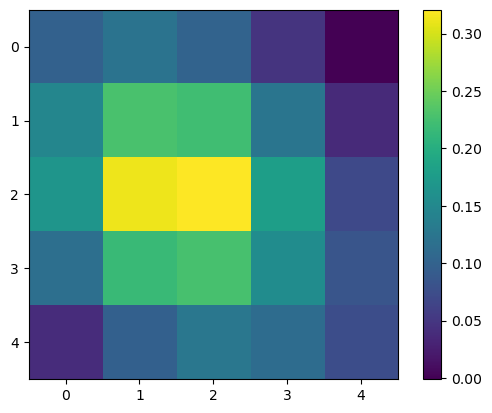

In [3]:
search_range = 2
im1, im2 = MIinput.GetImage(1070, cropROI=cropROI), MIinput.GetImage(1000, cropROI=cropROI)
Xcorr = RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, MaximizeReference=True)
plt.imshow(Xcorr)
plt.colorbar()

Compare execution times:

In [5]:
%timeit RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, MaximizeReference=False)
%timeit RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, MaximizeReference=True)

554 µs ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
799 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Compare results with and without maximizing reference:

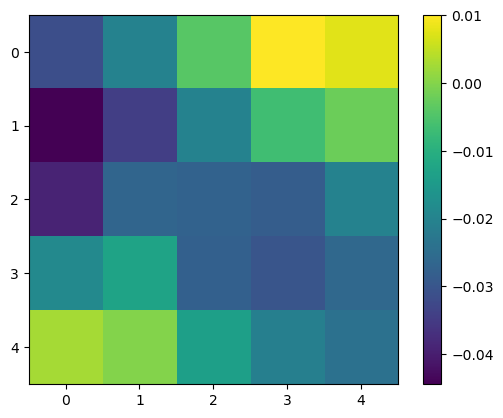

In [6]:
plt.imshow(RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, MaximizeReference=True) - RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, MaximizeReference=False))
plt.colorbar()

Compare impact of SearchRange with and without maximizing reference:

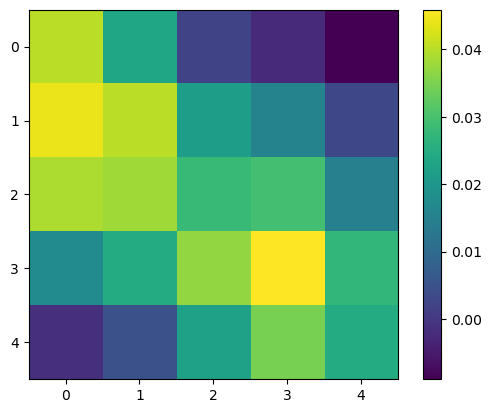

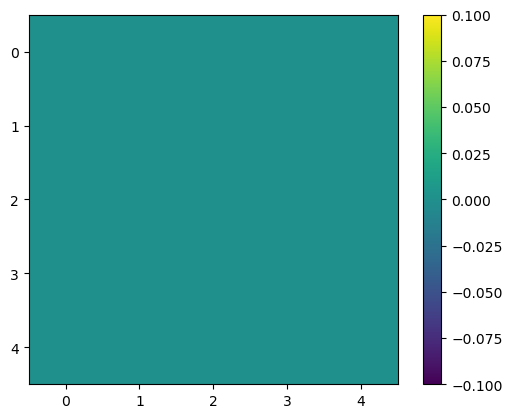

In [7]:
plt.imshow(RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range+1, SearchROI=None, ValidateInput=True, MaximizeReference=False)[1:-1,1:-1] 
           - RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, MaximizeReference=False))
plt.colorbar()
plt.figure()
plt.imshow(RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range+1, SearchROI=None, ValidateInput=True, MaximizeReference=True)[1:-1,1:-1] 
           - RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, MaximizeReference=True))
plt.colorbar()

### Tracking crosscorrelation peak

For a translating speckle pattern, $ c_I(t, \tau, \vec{\delta})$ shows a peak for a value of $\vec{\delta}_p(t, \tau)$ matching the translation between time $t$ and time $t+\tau$. The peak value is 1 for a pure rigid translation, and decreases if speckle *boiling* dynamics is superimposed to the translation.
The value of $\vec{\delta}_p$, as well as the peak height $ c_I(t, \tau, \vec{\delta}_p)$ can be extracted from the crosscorrelation matrix using the function

```python
delta_x, delta_y, peak_height = FindSubpixelPeak(Matrix, TopLeftCoord=(0,0), Method='paraboloid')
```

where:
- ```Matrix``` is the input crosscorrelation matrix
- ```TopLeftCoord``` is a couple of values specifying the coordinates of the top-left corner of the matrix
- ```Method``` : ```['paraboloid', 'overlap']``` specifies the method to compute the position with subpixel resolution
    - ```'paraboloid'```: approximate the peak height with a 2D paraboloid, use peak neighborhood to fix paraboloid coefficients, find vertex height and position. Works best with larger speckles
    - ```'overlap'```: Luca's method, optimized for small speckles

**PARABOLOID**

Let's test the paraboloid method first:

In [8]:
delta_x, delta_y, peak_height = RP.FindSubpixelPeak(Xcorr, TopLeftCoord=(-search_range,-search_range), Method='paraboloid')
print('dx={0}; dy={1}; corr_peak={2}'.format(delta_x, delta_y, peak_height))

dx=-0.47463551688378947; dy=-0.01724500071331403; corr_peak=0.3366299034992277


The function assumes that the correlation peak has a parabolic shape, and extract the 6 coefficients of the paraboloid $z = a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) + a_3(x-x_0)(y-y_0) + a_4(y-y_0) + a_5(y-y_0)(y-y_1)$ from the value of 6 pixels around the absolute maximum of ```Xcorr```. Here, $x_0, x_1, y_0, y_1$ are pixel-discretized coordinates around the maximum. 5 out of the 6 pixels are fixed to a cross centered in the absolute maximum: they are used to fix ${a_0, a_1, a_2, a_4, a_5}$. There are 4 natural choices for the 6th point needed to fix $a_3$: the program computes the coordinates averages on all four of them using the function ```FindParabolaExt(_corr, _x0, _y0, _x3, _y3, _a0, _a1, _a2, _a4, _a5)```, and then averages on all four choices.

**OVERLAP**

The overlap method is more complex: first, we need to find the crosscorrelation peak position with pixel resolution:

In [5]:
px_peak_x, px_peak_y, px_peak_z = RP.FindSubpixelPeak(Xcorr, Method='none')
print('Pixel-resolved peak position is {0}, max value is {1}'.format([px_peak_x, px_peak_y], px_peak_z))

Pixel-resolved peak position is [2, 2], max value is 0.3208485032806772


compute the covariance matrix:

$$
covar[J,I](\delta_x, \delta_y) = \langle J(x,y)I(x+\delta_x,y+\delta_y)\rangle _{x,y} - \langle I\rangle\langle J\rangle
$$

We can compute it by ```CalcCrosscorrMatrix(Image, Reference, Normalized=False)```

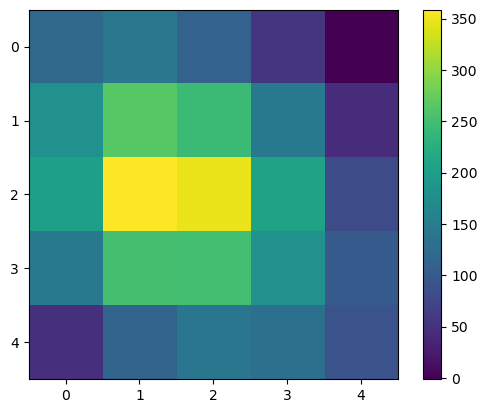

In [10]:
plt.imshow(RP.CalcCrosscorrMatrix(im1, im2, SearchRange=search_range, SearchROI=None, ValidateInput=True, MaximizeReference=True, Normalized=False))
plt.colorbar()

The whole analysis can be done by calling the function

```python
delta_x, delta_y, peak_height = ROIproc.FindCrosscorrPeak(Image, Reference, SearchRange, SearchROI=None, SubgridShape=None, ValidateInput=True)
```

where most parameters are the same as the ones discussed above for ```ROIproc.CalcCrosscorrMatrix```.

In [12]:
delta_x, delta_y, peak_height = RP.FindCrosscorrPeak(im1, im2, SearchRange=search_range, Method='paraboloid')
print('dx={0}; dy={1}; corr_peak={2}'.format(delta_x, delta_y, peak_height))

dx=-0.4567546901964723; dy=-0.016011821337505783; corr_peak=0.9759998659878033


### Dividing analysis in subgrid

In addition, ```ROIproc.FindCrosscorrPeak``` has a parameter ```SubgridShape```, which can be either ```None``` or couple of ```int``` (M,N). It is used to eventually divide the validated ```SearchROI``` into a grid of MxN ROIs (M ROIs along x axis, N along y axis), and process drifts independently in each subROI, to obtain statistics (average and standard deviation). ```None``` corresponds to ```(1,1)```

In [13]:
delta_x_avg, delta_y_avg, peak_height_avg, delta_x_std, delta_y_std, peak_height_std = RP.FindCrosscorrPeak(MIinput.GetImage(1), MIinput.GetImage(0), SearchRange=2, SubgridShape=(2,2))
print('dx={0}+/-{1}; dy={2}+/-{3}; corr_peak={4}+/-{5}'.format(delta_x_avg, delta_x_std, delta_y_avg, delta_y_std, peak_height_avg, peak_height_std))

DEBUG:root:Processing 4 subgrid regions


dx=-0.005827109487743898+/-0.003749912826309468; dy=0.0019957852398765352+/-0.0023038747497307584; corr_peak=0.9989932504475812+/-0.00034160421991776083


Dividing into a 2x2 grid suggests that we have a 0.005px uncertainty on peak position and better than 0.1% uncertainty on peak height. This should depend on the number of pixels, $N_{px}$, in the ROI used for the analysis: according to central limit theorem, variance should scale with $\sigma^2 \sim 1/N_{px}$ if noise is purely statistical, otherwise it should have a nonzero intercept for $1/N_{px}\rightarrow 0$ if there is another source of noise. In our case it looks purely statistical, and a ROI with $N_{px}=10^4$ pixels should give better than 0.01px accuracy on peak displacement and better than 0.1% accuracy on peak height 

In [ ]:
Nlist = np.asarray([2,4,8,16,32])
subROIpxNum = np.asarray([np.prod(MIinput.ImageShape())/N**2 for N in Nlist])
stat_res = np.empty((len(Nlist), 6), dtype=float)
for i in range(len(Nlist)):
    stat_res[i] = RP.FindCrosscorrPeak(MIinput.GetImage(1), MIinput.GetImage(0), SearchRange=2, SubgridShape=(Nlist[i],Nlist[i]))

fig, ax = plt.subplots()
ax.plot(1/subROIpxNum, stat_res[:,3]**2, 'bo:', label='dx')
ax.plot(1/subROIpxNum, stat_res[:,4]**2, 'rs:', label='dy')
ax.plot(1/subROIpxNum, stat_res[:,5]**2, 'g^:', label='peak')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/N_{px}$')
ax.set_ylabel(r'$\sigma^2$')
ax.legend()

### Integration in doDLS

This *drift correction* can be integrated in the ```doDLS``` analysis by activating the ```drift_corr``` option (no ```SubgridShape``` option available here). Note, however, that this also requires that the ROI bounding box is defined with a ```BoundingBoxMargin``` at least equal to the maximum drift. This parameter can be changed by calling ```ROIproc.UpdateBBmargin(BoundingBoxMargin)```:

In [ ]:
print('Bounding box before (margin={0}): {1}'.format(ROI_proc.BoundingBoxMargin, ROI_proc.BoundingBox))
ROI_proc.UpdateBBmargin(10)
print('Bounding box after (margin={0}): {1}'.format(ROI_proc.BoundingBoxMargin, ROI_proc.BoundingBox))

im1_crop = ROI_proc.GetImage(0)
print('Bounding box shape is: ' + str(im1_crop.shape))
fig, ax = plt.subplots()
ax.imshow(im1_crop, interpolation='none', extent=(0, ROI_proc.CropROIbb[2], ROI_proc.CropROIbb[3], 0))
for ridx in range(len(ROI_proc.ROI_masks_crop)):
    _rbb = ROI_proc.ROIboundingBoxes[ridx]
    if ROI_proc.ROI_masks_crop is not None:
        ax.imshow(ROI_proc.ROI_masks_crop[ridx], interpolation='none', extent=(_rbb[1], _rbb[3], _rbb[2], _rbb[0]), vmin=0, vmax=1)
    ax.add_patch(patches.Rectangle((_rbb[1], _rbb[0]), _rbb[3]-_rbb[1], _rbb[2]-_rbb[0], edgecolor='r', facecolor='none'))
ax.set_xlim([0, ROI_proc.CropROIbb[2]])
ax.set_ylim([ROI_proc.CropROIbb[3], 0])

print('ROIboundingBoxes:')
print(ROI_proc.ROIboundingBoxes)

Once updated ```BoundingBoxMargin```, we can compute ROI-resolved sparial crosscorrelations:

In [ ]:
XcorrROI = RP.CalcCrosscorrMatrix(MIinput.GetImage(1), MIinput.GetImage(0), SearchRange=search_range, SearchROI=ROI_proc.ROIboundingBoxes[3], ValidateInput=True)
plt.imshow(XcorrROI)
plt.colorbar()

In [ ]:
RP.ValidateShiftROI(ROI_proc.ROIboundingBoxes[0], 10, ROI_proc.GetCroppedShape(), debugMode=True)

This drift correction is integrated in ```ROI_proc.doDLS()``` function if the ```drift_corr``` is set to a positive value (corresponding to ```search_range``` above):

In [ ]:
%%time
fout_drift=os.path.join(froot, 'out_drift')
ROI_proc.doDLS(fout_drift, lagtimes='all', reftimes='all', drift_corr=10, no_buffer=True, force_SLS=True, save_transposed=False)

In this particular case, same-pixel correlations decay pretty fast, whereas the height of the crosscorrelation peak is almost constant, indicating that the speckles are just translating rigidly:

In [ ]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout_drift, fname_prefix='g2m1_')
g2m1cr_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout_drift, fname_prefix='g2m1cr_')
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='cI_ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
    plt.plot(lagtimes[i][0][1:], g2m1cr_data[i][0][1:], ls='--', label='cIcr_ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()

The time-averaged output files can be used to quantify the drift:

In [ ]:
dx_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout_drift, fname_prefix='avgdx_')
dy_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout_drift, fname_prefix='avgdy_')
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], dx_data[i][0][1:], label='dx_ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
    plt.plot(lagtimes[i][0][1:], dy_data[i][0][1:], ls='--', label='dy_ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()

Incidentally, drift-corrected analysis can be saved in transposed format as well, and can be reload and rerun from config file

In [ ]:
ROI_proc_drift_reload = RP.LoadFromConfig(os.path.join(fout_drift, 'ROIprocConfig.ini'), runAnalysis=True)

In [ ]:
%%time
fout_drift_trans=os.path.join(froot, 'out_drift_trans')
ROI_proc.doDLS(fout_drift_trans, lagtimes='all', reftimes=[3], drift_corr=10, no_buffer=True, force_SLS=True, save_transposed=True, include_negative_lags=True)